# Creating Binary Cassification NN Model

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from keras_tuner import RandomSearch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ann_visualizer.visualize import ann_viz

### Split the Train/Test set (80% Train (40% tune, 40% train), 20% Test)

In [9]:
# Load dataset
df = pd.read_csv("../datasets/binarydataset.csv",index_col=0)
df

,datetime,IncidentTime,Call,Holiday,Morning,Afternoon,Night,Monday,Tuesday,Wednesday,...,Saturday,Sunday,temp,snowdepth,windspeed,Clear,Cloudy,Overcast,Rain,Snow
0,2001-01-01,NaN,0,1,0,0,0,1,0,0,...,0,0,26.2,9.2,15.7,0,1,0,0,0
1,2001-01-02,NaN,0,0,0,0,0,0,1,0,...,0,0,22.5,7.3,15.8,0,1,0,0,0
2,2001-01-03,15:00:00,1,0,0,1,0,0,0,1,...,0,0,22.3,6.8,11.1,0,1,0,0,0
3,2001-01-04,NaN,0,0,0,0,0,0,0,0,...,0,0,27.6,6.3,14.0,0,1,0,0,0
4,2001-01-05,NaN,0,0,0,0,0,0,0,0,...,0,0,26.4,6.6,10.2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9361,2022-11-20,09:07:59,1,0,1,0,0,0,0,0,...,0,1,29.8,0.0,17.6,1,0,0,0,0
9362,2022-11-21,NaN,0,0,0,0,0,1,0,0,...,0,0,31.1,0.0,11.8,1,0,0,0,0
9363,2022-11-22,13:26:42,1,0,0,1,0,0,1,0,...,0,0,38.2,0.0,8.0,1,0,0,0,0
9364,2022-11-23,NaN,0,0,0,0,0,0,0,1,...,0,0,36.7,0.0,10.2,1,0,0,0,0


In [10]:
X = df.iloc[:, 3:]  # Returns Features
Y = df.iloc[:, 2]  # Returns Calls
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=32)

### Create Binary Classification Model (Sequential)
Layers:
1. Flatten 18 features to input data
2. Hidden layer between 20 - 320 neurons w/ ReLu activation  
3. Output layer w/ Sigmoid activation

Hyperparameters being tuned
1. Amount of neurons in first layer w/ 40 steps 
2. Learning Rate [1e-1, le-4]

In [11]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(19,)))  # Input Layer (18=features)
    model.add(Dense(units=hp.Int("units", min_value=20, max_value=320, step=40),
              activation="relu", name="Hidden_layer1"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="Output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model

## Create deep neural network model with 1-5 layers
NOTE: Not used within tuning/training since accuracy doesn't improve

In [12]:
def build_model_layerN(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(19,)))  # Input Layer (10=features)

    # Finds how many layers should be in NN
    for layer in range(hp.Int("num_layers", 1, 5)):
        model.add(Dense(units=hp.Int("units_" + str(layer), min_value=20, max_value=320,
                  step=40), activation="relu"))  # Find best amount of neurons for layer
    model.add(Dense(1, activation="sigmoid", name="output_layer"))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[
                  1e-2, 1e-4])), loss='binary_crossentropy', metrics=["accuracy"])  # Adam = SGD
    return model

### Find the best hyperparameters for TrainingSet using RandomSearch
How to determine max_trails and executions_per_trail https://medium.com/@avengers14.blogger/what-are-max-trials-and-executions-per-trial-in-keras-tuner-68ef9a18497d

In [13]:
# Stop training when loss doesn't imporve in 1 epoches
callback = EarlyStopping(monitor="loss", min_delta=.01, patience=5)
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    directory='binary_trails',  # Store results
    project_name='FirePredict',
    overwrite=True, 
    max_trials=32,  # Bc 16 steps x 2 learning_rates
    executions_per_trial=3  # How many times to train verison of model
)

In [14]:
tuner_n_layers = RandomSearch(
    build_model_layerN,
    objective='val_accuracy',
    directory='trails_directory_V2',  # Store results
    project_name='FirePredict',
    overwrite=True, # Delete Previous Trails Files
    max_trials=160,  # Bc 16 steps x 2 learning_rates x 5 potential layers
    executions_per_trial=3  # How many times to train verison of model
)
tuner.search(X_train, Y_train, callbacks=[callback], validation_split=.5)

Trial 12 Complete [00h 00m 04s]
val_accuracy: 0.4957287907600403

Best val_accuracy So Far: 0.4957287907600403
Total elapsed time: 00h 00m 48s
INFO:tensorflow:Oracle triggered exit


## Obtain the best hyperparameters to be used within training of model

In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# accuracy = train accuracy, val_accuracy = test accuracy
history = model.fit(X_train, Y_train, epochs=50, callbacks=[callback], validation_split=.5)

Epoch 1/50
118/118 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5171 - val_loss: 0.6938 - val_accuracy: 0.4957
Epoch 2/50
118/118 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5166 - val_loss: 0.6937 - val_accuracy: 0.4957
Epoch 3/50
118/118 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5166 - val_loss: 0.6947 - val_accuracy: 0.4957
Epoch 4/50
118/118 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5166 - val_loss: 0.6942 - val_accuracy: 0.4957
Epoch 5/50
118/118 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5166 - val_loss: 0.6938 - val_accuracy: 0.4957
Epoch 6/50
118/118 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5166 - val_loss: 0.6941 - val_accuracy: 0.4957


# Stats about Neural Network Model

Training and Validation set accuracy

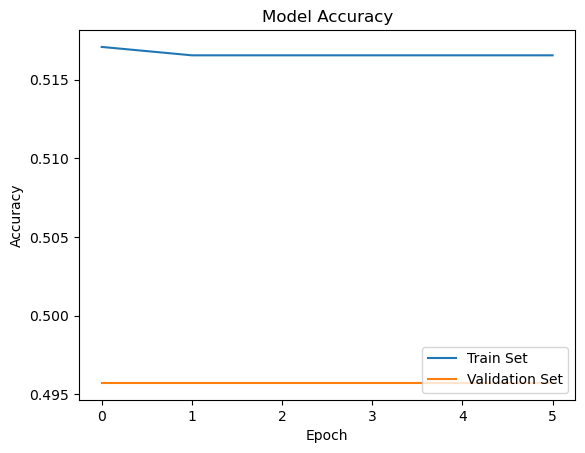

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 19)                0         
                                                                 
 Hidden_layer1 (Dense)       (None, 300)               6000      
                                                                 
 Output_layer (Dense)        (None, 1)                 301       
                                                                 
Total params: 6,301
Trainable params: 6,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Set", "Validation Set"], loc="lower right")
plt.show()
model.summary()

Training and Validation Loss

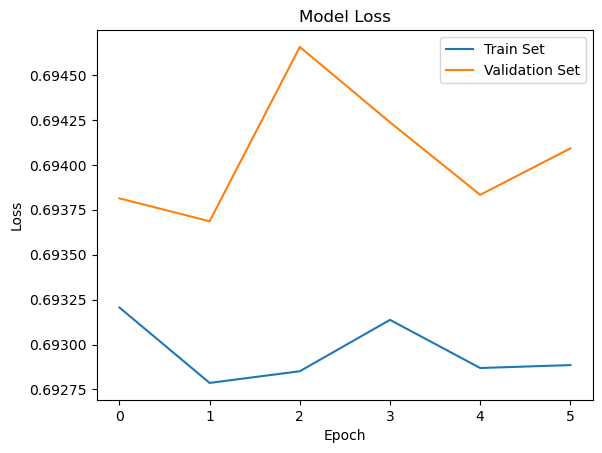

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.show()

In [18]:
loss, accuracy = model.evaluate(X_test,Y_test)

59/59 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5037
